In [1]:
### JUPYTER NOTEBOOK / MODULE PATH FIX ###
import sys

if "/share/apps/python/3.8.6/intel/lib/python3.8" in sys.path and sys.path[1] == '':
    sys.path[1], sys.path[6] = sys.path[6], sys.path[1]

In [2]:
from jtb_2022_code.utils.figure_common import *
from jtb_2022_code.utils.adata_common import *
from jtb_2022_code.utils.pseudotime_common import *
from jtb_2022_code import FigureSingleCellData
from inferelator_prior.velocity import decay
import numpy as np
import pandas as pd

In [3]:
## LOAD AND PROCESS UMAP FOR UMAP PANELS ###
data = FigureSingleCellData()

#def remove_velocity(x):
#    del x.layers['denoised_velocity']

#data.apply_inplace_to_expts(calculate_times_velocities, 
#                            layer='denoised',
#                            transform_expr=np.expm1,
#                            distance_key='denoised_distances')

Reading Single Cell Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_fpr1.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_fpr1.h5ad


In [4]:
def _calc_decays(adata):
    decays, decays_se, alphas = decay.calc_decay(adata.layers['denoised'], adata.layers['denoised_velocity'], 
                                                 include_alpha=False, decay_quantiles=[0.01, 0.05], 
                                                 add_pseudocount=True, log_expression=True)
    adata.var['decay'] = decays
    adata.var['decays_se'] = decays_se
    
def _calc_halflives(adata):
    adata.var['halflife'] = np.log(2) / adata.var['decay']
    adata.var.loc[np.isinf(adata.var['halflife']), 'halflife'] = np.nan

data.apply_inplace_to_expts(_calc_decays)
data.apply_inplace_to_expts(_calc_halflives)

/share/apps/python/3.8.6/intel/lib/python3.8/site-packages/numpy-1.19.2-py3.8-linux-x86_64.egg/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
 10%|▉         | 546/5747 [00:00<00:02, 1803.99it/s]/share/apps/python/3.8.6/intel/lib/python3.8/site-packages/numpy-1.19.2-py3.8-linux-x86_64.egg/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/share/apps/python/3.8.6/intel/lib/python3.8/site-packages/numpy-1.19.2-py3.8-linux-x86_64.egg/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 5747/5747 [00:03<00:00, 1802.73it/s]
/share/apps/python/3.8.6/intel/lib/python3.8/site-packages/numpy-1.19.2-py3.8-linux-x86_64.egg/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
 

In [29]:
data.expt_data[(1, "WT")].var['halflife'].isna().sum()

3

In [24]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.stats

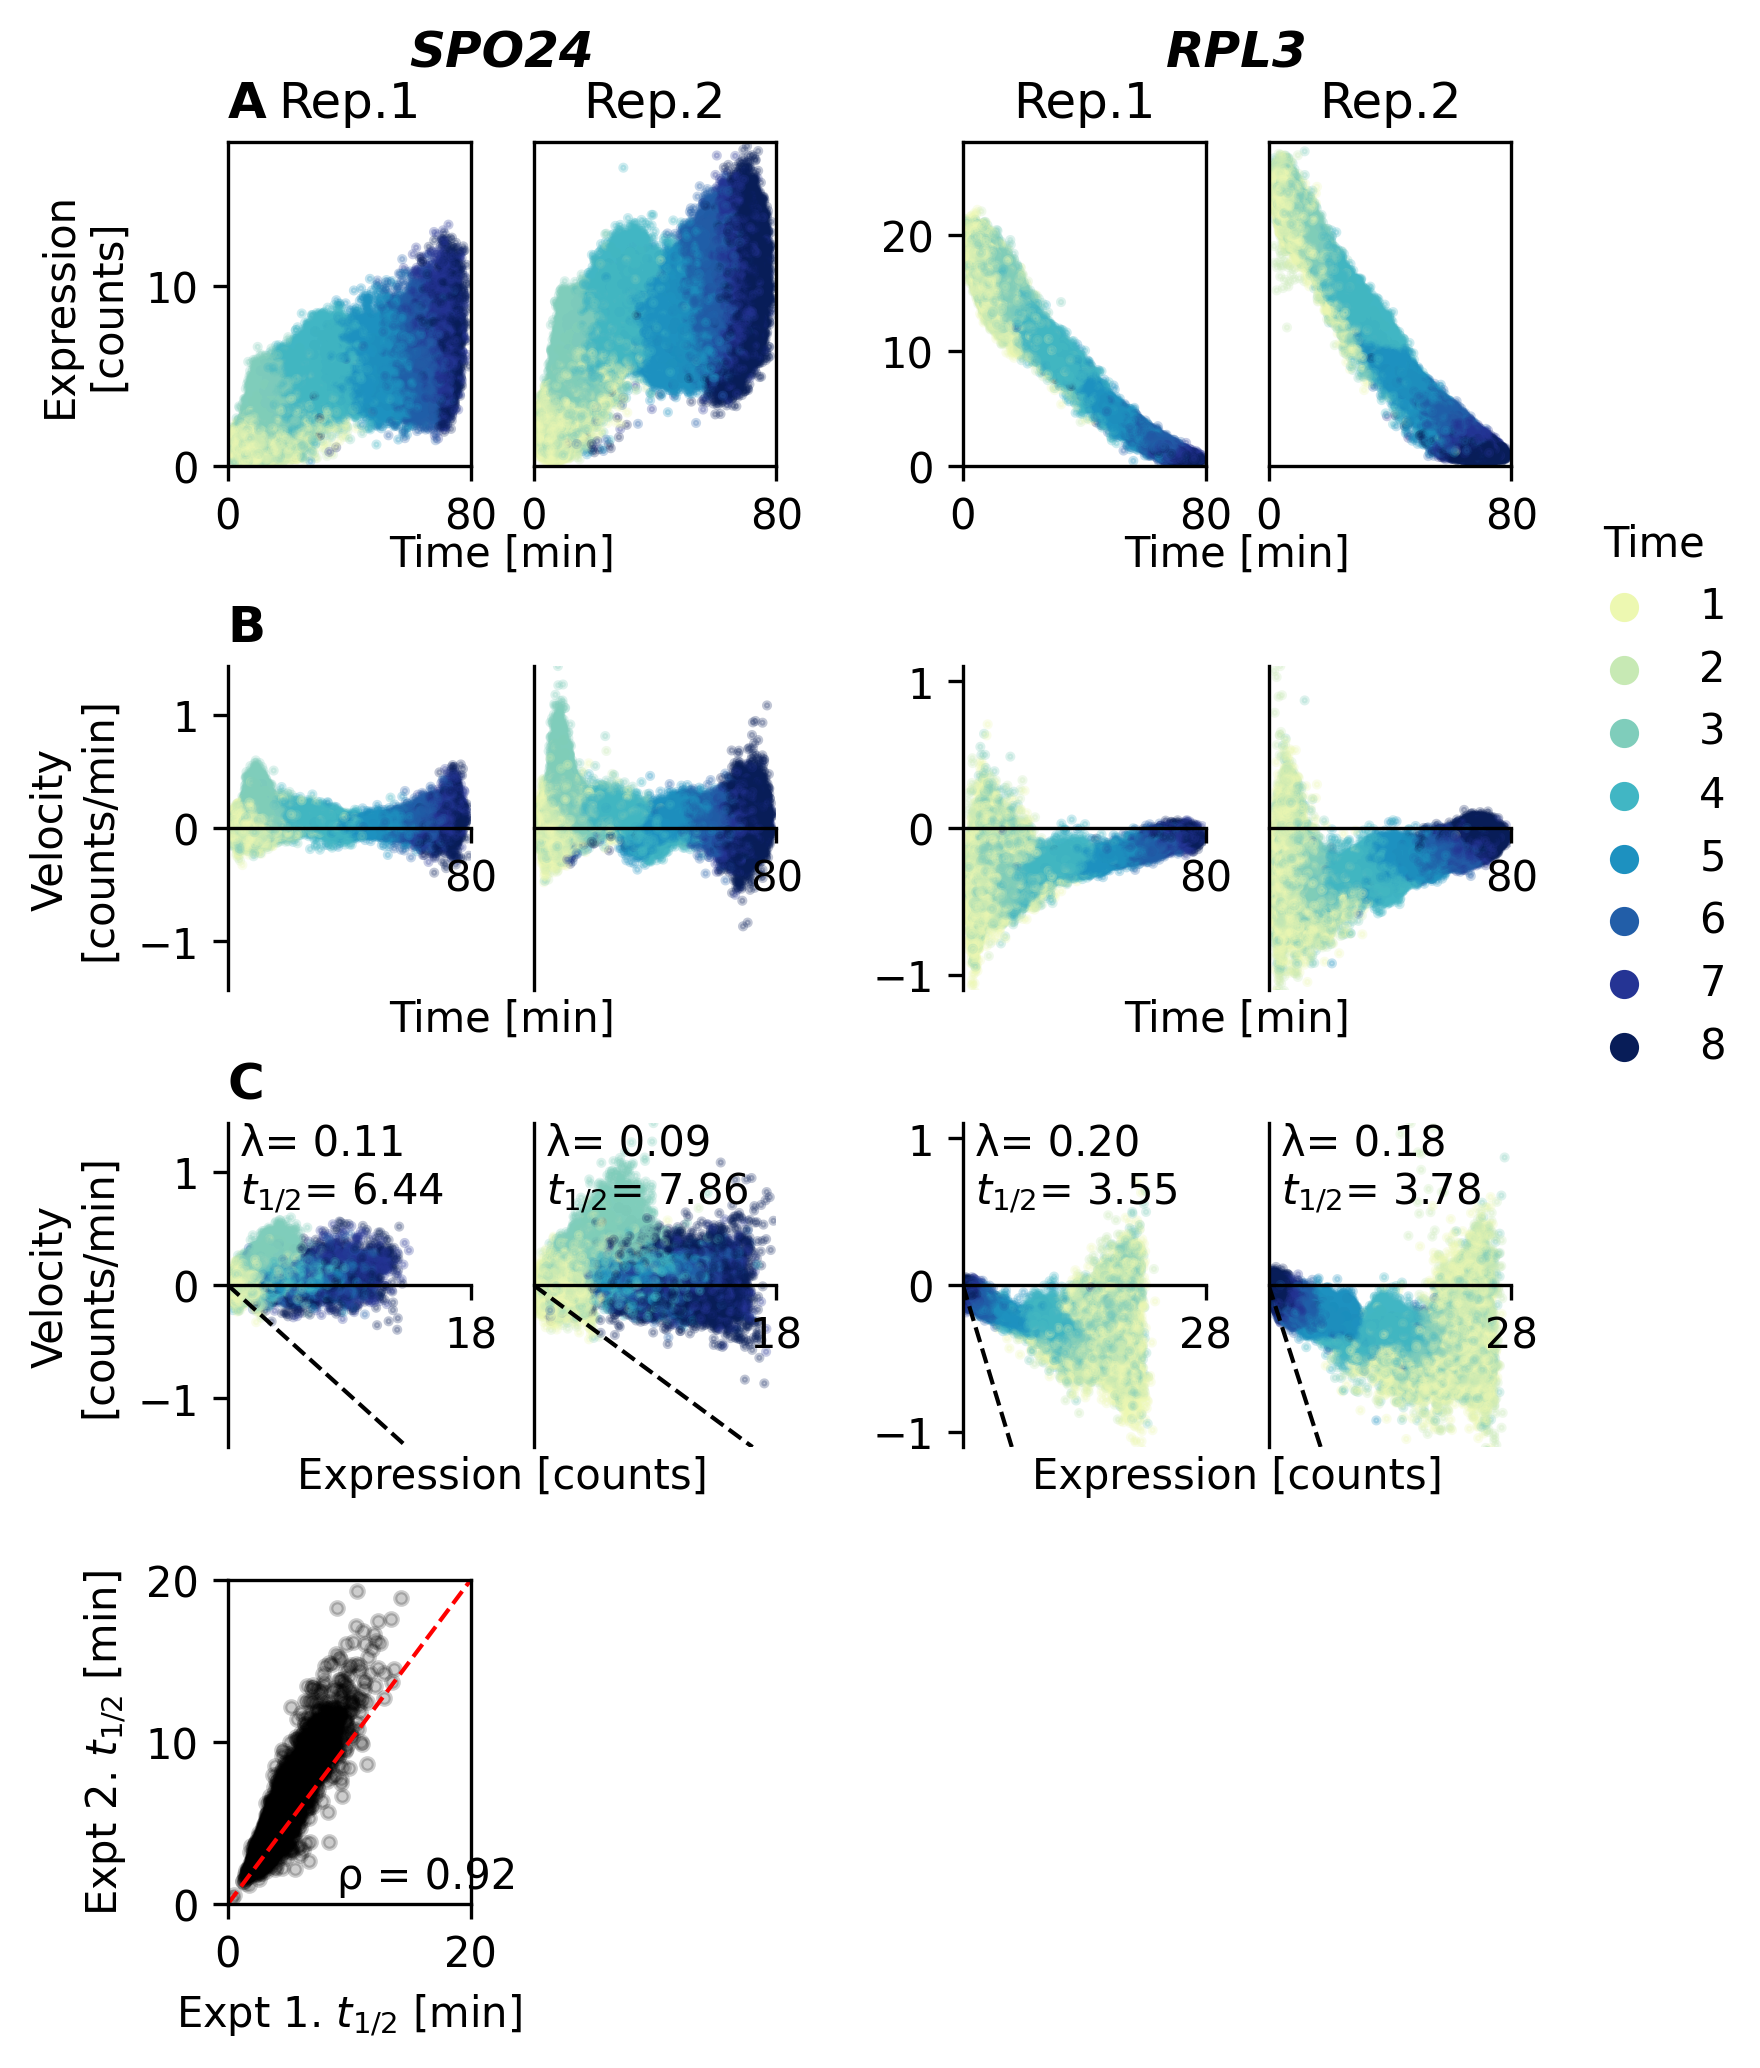

In [34]:
rgen = np.random.default_rng(100)

panel_genes = ["YPR036W-A", "YOR063W"]

panel_labels = {'expr_11': "A",
                'velocity_11': "B",
                'decay_11': "C"}

panel_titles = {'title_1': "SPO24",
                'title_2': "RPL3"}

x_axis_labelers = {'x_lab_11': ('Time [min]', 0), 
                   'x_lab_21': ('Time [min]', 0.9), 
                   'x_lab_31': ('Expression [counts]', 0.9), 
                   'x_lab_12': ('Time [min]', 0), 
                   'x_lab_22': ('Time [min]', 0.9), 
                   'x_lab_32': ('Expression [counts]', 0.9)}

layout = [['title_1', 'title_1', '.', 'title_2', 'title_2', '.'],
          ['expr_11', 'expr_21', '.', 'expr_12', 'expr_22', 'time_lgd'],
          ['x_lab_11', 'x_lab_11', '.', 'x_lab_12', 'x_lab_12', 'time_lgd'],
          ['.'] * 5 + ['time_lgd'],
          ['velocity_11', 'velocity_21', '.', 'velocity_12', 'velocity_22', 'time_lgd'],
          ['x_lab_21', 'x_lab_21', '.', 'x_lab_22', 'x_lab_22', 'time_lgd'],
          ['decay_11', 'decay_21', '.', 'decay_12', 'decay_22', 'time_lgd'],
          ['x_lab_31', 'x_lab_31', '.', 'x_lab_32', 'x_lab_32', '.'],
          ['hl_corr'] + ['.'] * 5]

fig_refs = {}

fig, axd = plt.subplot_mosaic(layout,
                              gridspec_kw=dict(width_ratios=[1, 1, 0.25, 1, 1, 0.2], 
                                               height_ratios=[0.05, 1, 0.2, 0.1, 1, 0.2, 1, 0.2, 1],
                                               wspace=0.35), 
                              figsize=(6, 8), dpi=300)

def _minmax(arr):
    return np.min(arr), np.max(arr)

def _minmax_list(lst):
    return min(l[0] for l in lst), max(l[1] for l in lst)

def _get_limits(layer, mod_func=lambda x: x, symmetric=False):
    limits = {g: _minmax_list([_minmax(mod_func(data.expt_data[(j, k)].layers[layer][:, data.expt_data[(j, k)].var_names == g])) 
                              for j in range(1, 3) 
                              for k in ["WT"]]) 
              for g in panel_genes}
    
    if not symmetric:
        return {g: (np.floor(v[0]), np.ceil(v[1])) for g, v in limits.items()}
    else:
        return {g: (-1 * np.max(v), np.max(v)) for g, v in limits.items()}
    

expr_limits = _get_limits('denoised', mod_func = np.expm1)
velocity_limits = _get_limits('denoised_velocity', symmetric=True)

for a in ['title_1', 'title_2', 'time_lgd']:
    axd[a].axis('off')
    
for axid, (lab, yoff) in x_axis_labelers.items():
    axd[axid].axis('off')
    axd[axid].annotate(lab, (0.5, yoff), xycoords='axes fraction', ha='center')


def _minmax(arr):
    return np.min(arr), np.max(arr)

def _minmax_list(lst):
    return min(l[0] for l in lst), max(l[1] for l in lst)

def _get_limits(layer, mod_func=lambda x: x, symmetric=False):
    limits = {g: _minmax_list([_minmax(mod_func(data.expt_data[(j, k)].layers[layer][:, data.expt_data[(j, k)].var_names == g])) 
                              for j in range(1, 3) 
                              for k in ["WT"]]) 
              for g in panel_genes}
    
    if not symmetric:
        return {g: (np.floor(v[0]), np.ceil(v[1])) for g, v in limits.items()}
    else:
        return {g: (-1 * np.max(v), np.max(v)) for g, v in limits.items()}
    

expr_limits = _get_limits('denoised', mod_func = np.expm1)
velocity_limits = _get_limits('denoised_velocity', symmetric=True)

def _replot_axes(ax):
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')
               
for j in range(1, 3):
    pdata = data.expt_data[(j, "WT")]
    for i, g in enumerate(panel_genes):
        g_idx = pdata.var_names == g
        
        overplot_shuffle = np.arange(pdata.shape[0])
        rgen.shuffle(overplot_shuffle)
        
        time_data = pdata.obs['time_pca_pt'].values[overplot_shuffle]
        expr_data = np.expm1(pdata.layers['denoised'][:, g_idx]).flatten()[overplot_shuffle]
        velocity_data = pdata.layers['denoised_velocity'][:, g_idx].flatten()[overplot_shuffle]
        color_data = pdata.obs['Pool'].map({k: v for k, v in zip(range(1, 9), pool_palette())}).values[overplot_shuffle]
        
        ### PANEL A ###
        a_ref = "expr_" + str(j) + str(i + 1)
        fig_refs[a_ref] = axd[a_ref].scatter(x=time_data, 
                                             y=expr_data,
                                             c=color_data,
                                             alpha=0.25, 
                                             s=2)
        axd[a_ref].set_xlim(0, 80)
        axd[a_ref].set_xticks([0, 80])
        axd[a_ref].set_ylim(*expr_limits[g])
        axd[a_ref].set_yticks([]) if j == 2 else None
        axd[a_ref].set_ylabel("Expression\n[counts]") if j == 1 and i == 0 else None
        axd[a_ref].set_title("Rep." + str(j))
        
        ### PANEL B ###
        b_ref = "velocity_" + str(j) + str(i + 1)
        fig_refs[b_ref] = axd[b_ref].scatter(x=time_data, 
                                             y=velocity_data,
                                             c=color_data,
                                             alpha=0.25, 
                                             s=2)
        
        axd[b_ref].set_xlim(0, 80)
        axd[b_ref].set_xticks([80])
        axd[b_ref].set_ylim(*velocity_limits[g])
        axd[b_ref].set_yticks([]) if j == 2 else None
        axd[b_ref].set_ylabel("Velocity\n[counts/min]") if j == 1 and i == 0 else None

        _replot_axes(axd[b_ref])
        
        ### PANEL C ###
        c_ref = "decay_" + str(j) + str(i + 1)
        fig_refs[c_ref] = axd[c_ref].scatter(x=expr_data, 
                                             y=velocity_data,
                                             c=color_data,
                                             alpha=0.25, 
                                             s=2)
        
        axd[c_ref].set_xlim(*expr_limits[g])
        axd[c_ref].set_xticks([expr_limits[g][1]])
        axd[c_ref].set_ylim(*velocity_limits[g])
        axd[c_ref].set_yticks([]) if j == 2 else None
        axd[c_ref].set_ylabel("Velocity\n[counts/min]") if j == 1 and i == 0 else None

        _replot_axes(axd[c_ref])
        
        decay_constant = pdata.var.loc[g_idx, 'decay'][0]
        half_life = np.log(2) / decay_constant
        axd[c_ref].axline((0, 0), slope = -1 * decay_constant, c="black", linestyle='--', linewidth=1.0)
        axd[c_ref].annotate(f"λ= {decay_constant:.2f}\n" + "$t_{1/2}$= " + f"{half_life:.2f}", 
                            xy=(5, 0.2),  xycoords='data', xytext=(0.05, 0.75), textcoords='axes fraction')

        
fig_refs['time_lgd'] = add_legend(axd['time_lgd'], 
                                  pool_palette(), 
                                  data.all_data.obs['Pool'].dtype.categories.values,
                                  title="Time")

### Half-life correlation plot ###
hl_x = data.expt_data[(1, "WT")].var['halflife']
hl_y = data.expt_data[(2, "WT")].var['halflife']
drop_na_idx = hl_x.isna() | hl_y.isna()
hl_x = hl_x.loc[~drop_na_idx]
hl_y = hl_y.loc[~drop_na_idx]

hl_rho = scipy.stats.spearmanr(hl_x, hl_y)[0]
fig_refs['hl_corr'] = axd['hl_corr'].scatter(x=hl_x, y=hl_y, 
                                             c='black', alpha=0.2, marker='.')
axd['hl_corr'].set_xlabel("Expt 1. $t_{1/2}$ [min]")
axd['hl_corr'].set_ylabel("Expt 2. $t_{1/2}$ [min]")
axd['hl_corr'].set_xlim(0, 20)
axd['hl_corr'].set_ylim(0, 20)
axd['hl_corr'].axline((0, 0), slope = 1, c='red', linestyle='--', linewidth=1.0)
axd['hl_corr'].annotate(f"ρ= {hl_rho:.2f}",
                        xy=(5, 0.2),  xycoords='data', xytext=(0.45, 0.05), textcoords='axes fraction')

for ax_id, label in panel_titles.items():
    axd[ax_id].set_title(label, fontdict={'fontweight': 'bold', 'fontstyle': 'italic'})

for ax_id, label in panel_labels.items():
    axd[ax_id].set_title(label, loc='left', weight='bold')
    
fig.savefig(FIGURE_3_FILE_NAME + ".png", facecolor='white')
        

In [32]:
hl_pearson

(0.5527457563683338, 0.0)